### Set up

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys

sys.path.insert(0, '..')

In [3]:
import mlflow

In [4]:
mlflow.set_tracking_uri('http://localhost:2002')

In [5]:
import dill
import numpy as np
import pickle
import optuna
import pandas as pd
from ast import literal_eval
from optuna import Trial
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from src.features.embeddings import get_embeddings
from tqdm.notebook import tqdm
import xgboost as xgb
from src.features.embeddings import get_embeddings

In [48]:
def embed_text(texts):
    return get_embeddings(texts)

In [56]:
features = pd.read_csv("../data/data_version1/data_with_embeddings.csv")

In [57]:
features.head()

,Unnamed: 0,reason_combind,specialist_name,source_file,embedding
0,0,mất ngủ,thần kinh,reason_specialist - thần kinh.csv,"[0.04375111311674118, 0.03814738616347313, -0...."
1,1,rối loạn thần kinh thực vật,thần kinh,reason_specialist - thần kinh.csv,"[-0.09153086692094803, 0.053789976984262466, 0..."
2,2,đau đầu,thần kinh,reason_specialist - thần kinh.csv,"[-0.03125571087002754, 0.06346043944358826, -0..."
3,3,"đau đầu,đau sau ngực gần phổi",thần kinh,reason_specialist - thần kinh.csv,"[-0.036564845591783524, 0.041473038494586945, ..."
4,4,co giật 3 lần,thần kinh,reason_specialist - thần kinh.csv,"[-0.034981999546289444, 0.06580338627099991, -..."


In [58]:
features.isnull().sum()

Unnamed: 0         0
reason_combind     0
specialist_name    0
source_file        0
embedding          0
dtype: int64

In [59]:
features = features.dropna(subset=['reason_combind'])

In [60]:
features.shape

(53056, 5)

In [61]:
features['specialist_name'].unique(), len(features.specialist_name.unique())

(array(['thần kinh', 'nhi khoa', 'thận - tiết niệu', 'ung bướu',
        'hô hấp - phổi', 'chuyên khoa mắt', 'cơ xương khớp', 'tim mạch',
        'tiêu hoá', 'sức khỏe tâm thần', 'nội khoa',
        'tiểu đường - nội tiết', 'tai mũi họng', 'nam học', 'da liễu',
        'sản phụ khoa'], dtype=object),
 16)

In [62]:
class_distribution = features['specialist_name'].value_counts()
class_distribution

specialist_name
cơ xương khớp            8978
thần kinh                7527
da liễu                  5456
tiêu hoá                 5100
nội khoa                 4556
tai mũi họng             4106
sức khỏe tâm thần        3320
tim mạch                 3173
nam học                  2310
sản phụ khoa             1603
chuyên khoa mắt          1589
nhi khoa                 1467
ung bướu                 1361
thận - tiết niệu         1099
tiểu đường - nội tiết     761
hô hấp - phổi             650
Name: count, dtype: int64

In [69]:
np.average(class_distribution), int(np.average(class_distribution))

(np.float64(3316.0), 3316)

In [70]:
# Create a balanced dataset
# First, check the class distribution
class_distribution = features['specialist_name'].value_counts()
print(f"Original class distribution:\n{class_distribution}")
print(f"Number of classes: {len(class_distribution)}")

# Determine the minimum number of samples for balancing
min_samples_per_class = 50  # Set a minimum threshold
samples_per_class = max(min_samples_per_class, int(np.average(class_distribution)))
print(f"Taking {samples_per_class} samples per class")

# Create a balanced dataset by undersampling the majority classes
balanced_features = pd.DataFrame()

for specialist in features['specialist_name'].unique():
    specialist_data = features[features['specialist_name'] == specialist]
    
    # If the class has fewer samples than our target, take all of them
    # Otherwise, sample the required number
    if len(specialist_data) <= samples_per_class:
        balanced_data = specialist_data
    else:
        balanced_data = specialist_data.sample(n=samples_per_class, random_state=42)
    
    balanced_features = pd.concat([balanced_features, balanced_data])

# Shuffle the balanced dataset
balanced_features = balanced_features.sample(frac=1, random_state=42).reset_index(drop=True)

print(f"Original dataset shape: {features.shape}")
print(f"Balanced dataset shape: {balanced_features.shape}")

# Check the new class distribution
new_class_distribution = balanced_features['specialist_name'].value_counts()
print(f"New class distribution:\n{new_class_distribution}")

# Use the balanced dataset instead of the original one
features = balanced_features

Original class distribution:
specialist_name
cơ xương khớp            8978
thần kinh                7527
da liễu                  5456
tiêu hoá                 5100
nội khoa                 4556
tai mũi họng             4106
sức khỏe tâm thần        3320
tim mạch                 3173
nam học                  2310
sản phụ khoa             1603
chuyên khoa mắt          1589
nhi khoa                 1467
ung bướu                 1361
thận - tiết niệu         1099
tiểu đường - nội tiết     761
hô hấp - phổi             650
Name: count, dtype: int64
Number of classes: 16
Taking 3316 samples per class
Original dataset shape: (53056, 5)
Balanced dataset shape: (37225, 5)
New class distribution:
specialist_name
da liễu                  3316
tai mũi họng             3316
nội khoa                 3316
tiêu hoá                 3316
thần kinh                3316
cơ xương khớp            3316
sức khỏe tâm thần        3316
tim mạch                 3173
nam học                  2310
sản phụ khoa     

In [14]:
# Apply embeddings in batches to avoid memory issues
batch_size = 100
num_batches = len(features) // batch_size + (1 if len(features) % batch_size > 0 else 0)
embeddings = []

for i in tqdm(range(num_batches), desc="Generating embeddings"):
    start_idx = i * batch_size
    end_idx = min((i + 1) * batch_size, len(features))
    batch = features.iloc[start_idx:end_idx]
    texts = batch['reason_combind'].tolist()
    batch_embeddings = embed_text(texts)
    embeddings.extend(batch_embeddings)

features['embedding'] = embeddings

Generating embeddings:   0%|          | 0/531 [00:00<?, ?it/s]

In [24]:
features.head()

,Unnamed: 0,reason_combind,specialist_name,source_file,embedding
0,31289,"mất ngủ, bồn chồn, lo âu, tê bì chân tay, khô...",sức khỏe tâm thần,reason_specialist - sức khỏe tâm thần.csv,"[-0.029059259220957756, 0.04079094156622887, -..."
1,43874,"tinh hoàn bị giãn, khi vệ sinh cảm thấy rát",nam học,reason_specialist - nam học.csv,"[-0.035847753286361694, 0.04649074748158455, 0..."
2,7805,"con nhẹ cân, hay ốm",nhi khoa,reason_specialist - nhi khoa.csv,"[-0.06794720143079758, 0.050331488251686096, -..."
3,6347,suy nhuoc co thễ,thần kinh,reason_specialist - thần kinh.csv,"[-0.05049067363142967, 0.04926595464348793, -0..."
4,43246,"hay tắt tiếng không có nguyên do, từ sau bị co...",tai mũi họng,reason_specialist - tai mũi họng.csv,"[-0.024168703705072403, 0.14115726947784424, -..."


In [16]:
features.to_csv('../data/data_version1/data_with_embeddings.csv')

In [71]:
len(features.specialist_name.unique())

16

In [72]:
features['embedding'] = features.embedding.apply(literal_eval).apply(np.array)
# Convert the embedding column series to a numpy array
print(f"Embeddings shape: {features.embedding.shape}")

Embeddings shape: (37225,)


In [73]:
type(features.embedding[0])

numpy.ndarray

In [74]:
label_encoder = LabelEncoder()
features['target'] = label_encoder.fit_transform(features['specialist_name'])

In [75]:
with open('../models/xgboost-v5.1/label_encoder.pkl', 'wb') as f:
    pickle.dump(label_encoder, f)

In [76]:
features

,Unnamed: 0,reason_combind,specialist_name,source_file,embedding,target
0,47944,hiện tượng mẩn ngửa khoang tròn trên má trái đ...,da liễu,reason_specialist - da liễu.csv,"[0.005924609489738941, 0.11179705709218979, 0....",2
1,42635,đau lỗ tai,tai mũi họng,reason_specialist - tai mũi họng.csv,"[0.03429027646780014, 0.10086283832788467, 0.0...",9
2,23034,"khó thở , rối loạn nhịp tim",tim mạch,reason_specialist - tim mạch.csv,"[-0.03409986197948456, 0.08946364372968674, 0....",12
3,45420,tiểu buốt khó cương cứng,nam học,reason_specialist - nam học.csv,"[-0.0490536093711853, -0.0004359014274086803, ...",4
4,41893,ho khan 2 tuần,tai mũi họng,reason_specialist - tai mũi họng.csv,"[-0.04045047238469124, 0.10913944244384766, -0...",9
...,...,...,...,...,...,...
37220,28098,đầy bụng khó tiêu hóa..có tiền sử dạ dày đại t...,tiêu hoá,reason_specialist - tiêu hóa.csv,"[-0.06727835536003113, 0.031999602913856506, -...",13
37221,10477,hạch sau nách trái,ung bướu,reason_specialist - ung bướu.csv,"[-0.007214145734906197, 0.07839018106460571, -...",15
37222,16101,kiểm tra lại tổng thể vết thương do tai nạn xe...,cơ xương khớp,reason_specialist - cơ xương khớp.csv,"[-0.0017416810151189566, 0.0351942740380764, 0...",1
37223,2657,"mất ngủ kéo dài,suy nhược thần kinh, chóng mặt...",thần kinh,reason_specialist - thần kinh.csv,"[0.008117335848510265, -0.00019868150411639363...",10


In [77]:
len(features.target.unique()), features.target.unique(), features.specialist_name.unique()

(16,
 array([ 2,  9, 12,  4, 13, 11,  5,  6,  8, 10,  0,  1,  7, 15,  3, 14]),
 array(['da liễu', 'tai mũi họng', 'tim mạch', 'nam học', 'tiêu hoá',
        'thận - tiết niệu', 'nhi khoa', 'nội khoa', 'sức khỏe tâm thần',
        'thần kinh', 'chuyên khoa mắt', 'cơ xương khớp', 'sản phụ khoa',
        'ung bướu', 'hô hấp - phổi', 'tiểu đường - nội tiết'], dtype=object))

In [78]:
X = features.drop(columns=['target'])
y = features['target']

In [79]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [80]:
X_test.shape, X_train.shape

((7445, 5), (29780, 5))

### Random forest

In [81]:
clf = RandomForestClassifier(n_estimators=100)
clf.fit(np.stack(X_train.embedding.values), y_train)
preds = clf.predict(np.stack(X_test.embedding.values))
# probas = clf.predict_proba(X_test)

report = classification_report(y_test, preds)

In [82]:
print(report)

              precision    recall  f1-score   support

           0       0.90      0.90      0.90       318
           1       0.69      0.88      0.77       663
           2       0.76      0.89      0.82       663
           3       0.65      0.38      0.48       130
           4       0.73      0.75      0.74       462
           5       0.63      0.21      0.32       294
           6       0.37      0.27      0.31       663
           7       0.77      0.64      0.70       321
           8       0.82      0.84      0.83       663
           9       0.70      0.86      0.77       663
          10       0.63      0.63      0.63       663
          11       0.71      0.58      0.64       220
          12       0.74      0.82      0.78       635
          13       0.67      0.79      0.72       663
          14       0.61      0.28      0.39       152
          15       0.49      0.38      0.43       272

    accuracy                           0.69      7445
   macro avg       0.68   

In [83]:
label_encoder.inverse_transform([15, 14, 3, 5, 6])

array(['ung bướu', 'tiểu đường - nội tiết', 'hô hấp - phổi', 'nhi khoa',
       'nội khoa'], dtype=object)

In [ ]:
preds.tolist()

In [84]:
X_test['prediction'] = preds.tolist()

In [85]:
X_test['target'] = y_test.tolist()

In [86]:
X_test.head()

,Unnamed: 0,reason_combind,specialist_name,source_file,embedding,prediction,target
30051,11857,"phổi yếu sau covid,thở khò khè hay có đờm",hô hấp - phổi,reason_specialist - hô hấp phổi.csv,"[-0.029220951721072197, 0.08768092095851898, -...",3,3
22998,34107,tư vấn hôn nhân gia đình,sức khỏe tâm thần,reason_specialist - sức khỏe tâm thần.csv,"[-0.03123410977423191, 0.0074233063496649265, ...",8,8
24275,26428,"đi ngoài ra máu, sút cân mệt mỏi",tiêu hoá,reason_specialist - tiêu hóa.csv,"[-0.028077971190214157, 0.05117611959576607, -...",6,13
30348,12612,lác ngoài,chuyên khoa mắt,reason_specialist - chuyên khoa mắt.csv,"[-0.029618820175528526, -0.009993213228881359,...",2,0
1094,24366,"thở dài nhiều, thở không đều hơi",tim mạch,reason_specialist - tim mạch.csv,"[-0.026859989389777184, 0.08677642792463303, -...",9,12


In [87]:
# Find misclassifications
misclassified = X_test[X_test['prediction'] != X_test['target']]

# Display misclassified records with some context information
misclassified_with_labels = misclassified.copy()
misclassified_with_labels['predicted_specialist'] = label_encoder.inverse_transform(misclassified['prediction'])
misclassified_with_labels['actual_specialist'] = label_encoder.inverse_transform(misclassified['target'])

# Display results
print(f"Number of misclassified records: {len(misclassified)} out of {len(X_test)} test records")
print(f"Accuracy: {(len(X_test) - len(misclassified)) / len(X_test):.4f}")

# Show relevant columns for misclassified records
misclassified_display = misclassified_with_labels[['reason_combind', 'actual_specialist', 'predicted_specialist']]
misclassified_display.head(10)

Number of misclassified records: 2280 out of 7445 test records
Accuracy: 0.6938


,reason_combind,actual_specialist,predicted_specialist
24275,"đi ngoài ra máu, sút cân mệt mỏi",tiêu hoá,nội khoa
30348,lác ngoài,chuyên khoa mắt,da liễu
1094,"thở dài nhiều, thở không đều hơi",tim mạch,tai mũi họng
18149,điều trị,sản phụ khoa,tim mạch
19262,đau bung dau da dầy,tiêu hoá,da liễu
10131,trẻ 9 tuổi bị hội chứng thận hư đang uống thuố...,nhi khoa,nội khoa
11376,ra nhiều chất dịch màu trắng đục (giống bã đậu...,sản phụ khoa,da liễu
3929,sot,tai mũi họng,thần kinh
6952,dị ứng,da liễu,hô hấp - phổi
26075,dị ứng mẩn ngứa ko rõ nguyên nhân,nhi khoa,da liễu


In [88]:
misclassified_display.to_csv('../data/data_version1/misclassified_records.csv', index=False)

### XGboost

In [44]:
mlflow.set_experiment('xgboost_v6')

<Experiment: artifact_location='mlflow-artifacts:/398793586970850389', creation_time=1743751949295, experiment_id='398793586970850389', last_update_time=1743751949295, lifecycle_stage='active', name='xgboost_v6', tags={}>

In [45]:
def optimize_xgboost_model(trial: Trial):
    X, y = np.stack(X_train.embedding.values), y_train
    X, X_valid, y, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)
    param = {
        "max_depth": trial.suggest_int('max_depth', 3, 10),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.1),
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
        "gamma": trial.suggest_float("gamma", 0, 5),
    }

    model = xgb.XGBClassifier(
        **param,
        tree_method="hist"
    )

    with mlflow.start_run():
        bst = model.fit(X, y, eval_set=[(X, y), (X_valid, y_valid)], verbose=2)
        preds = bst.predict(np.stack(X_test.embedding.values))
        y_pred = np.rint(preds)
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average="weighted", zero_division=0)
        recall = recall_score(y_test, y_pred, average="weighted", zero_division=0)
        f1 = f1_score(y_test, y_pred, average="weighted", zero_division=0)

        mlflow.log_params(
            param
        )
        mlflow.log_metrics({
            "accuracy": accuracy,
            "precision": precision,
            "recall": recall,
            "f1_score": f1
        })    
    return accuracy

In [46]:
study = optuna.create_study(direction="maximize")
study.optimize(optimize_xgboost_model, n_trials=10, timeout=600)

[I 2025-04-09 12:07:45,492] A new study created in memory with name: no-name-48b3c28b-6dce-422d-9913-5e9040ef9302


[0]	validation_0-mlogloss:2.48856	validation_1-mlogloss:2.56465
[2]	validation_0-mlogloss:2.09858	validation_1-mlogloss:2.30524
[4]	validation_0-mlogloss:1.82197	validation_1-mlogloss:2.12451
[6]	validation_0-mlogloss:1.60538	validation_1-mlogloss:1.98976
[8]	validation_0-mlogloss:1.42879	validation_1-mlogloss:1.88168
[10]	validation_0-mlogloss:1.28314	validation_1-mlogloss:1.79191
[12]	validation_0-mlogloss:1.16106	validation_1-mlogloss:1.71700
[14]	validation_0-mlogloss:1.05709	validation_1-mlogloss:1.65440
[16]	validation_0-mlogloss:0.96615	validation_1-mlogloss:1.59883
[18]	validation_0-mlogloss:0.88854	validation_1-mlogloss:1.55041
[20]	validation_0-mlogloss:0.81922	validation_1-mlogloss:1.50864
[22]	validation_0-mlogloss:0.75957	validation_1-mlogloss:1.47277
[24]	validation_0-mlogloss:0.70711	validation_1-mlogloss:1.44144
[26]	validation_0-mlogloss:0.66054	validation_1-mlogloss:1.41237
[28]	validation_0-mlogloss:0.61900	validation_1-mlogloss:1.38650
[30]	validation_0-mlogloss:0.5

[I 2025-04-09 12:10:30,752] Trial 0 finished with value: 0.6596153846153846 and parameters: {'max_depth': 7, 'learning_rate': 0.08864964372141482, 'n_estimators': 283, 'subsample': 0.5836430230238419, 'colsample_bytree': 0.8895214533793604, 'min_child_weight': 1, 'gamma': 2.1872756893234753}. Best is trial 0 with value: 0.6596153846153846.


🏃 View run delicate-hen-244 at: http://localhost:2002/#/experiments/398793586970850389/runs/06f7138bc94d43eba0b4e5a4af7b5cbc
🧪 View experiment at: http://localhost:2002/#/experiments/398793586970850389
[0]	validation_0-mlogloss:2.60259	validation_1-mlogloss:2.63459
[2]	validation_0-mlogloss:2.35032	validation_1-mlogloss:2.43350
[4]	validation_0-mlogloss:2.15888	validation_1-mlogloss:2.28222
[6]	validation_0-mlogloss:2.00520	validation_1-mlogloss:2.16381
[8]	validation_0-mlogloss:1.87496	validation_1-mlogloss:2.06301
[10]	validation_0-mlogloss:1.76292	validation_1-mlogloss:1.98016
[12]	validation_0-mlogloss:1.66481	validation_1-mlogloss:1.90897
[14]	validation_0-mlogloss:1.57793	validation_1-mlogloss:1.84329
[16]	validation_0-mlogloss:1.50050	validation_1-mlogloss:1.78701
[18]	validation_0-mlogloss:1.42928	validation_1-mlogloss:1.73788
[20]	validation_0-mlogloss:1.36447	validation_1-mlogloss:1.69219
[22]	validation_0-mlogloss:1.30590	validation_1-mlogloss:1.65103
[24]	validation_0-mlogl

[I 2025-04-09 12:15:27,257] Trial 1 finished with value: 0.6634615384615384 and parameters: {'max_depth': 4, 'learning_rate': 0.05988290758995119, 'n_estimators': 446, 'subsample': 0.8013268848782054, 'colsample_bytree': 0.9716820050645093, 'min_child_weight': 2, 'gamma': 1.1231778092309674}. Best is trial 1 with value: 0.6634615384615384.


🏃 View run learned-pig-809 at: http://localhost:2002/#/experiments/398793586970850389/runs/a27e114125ec4783a93d249f1f4c6760
🧪 View experiment at: http://localhost:2002/#/experiments/398793586970850389
[0]	validation_0-mlogloss:2.66907	validation_1-mlogloss:2.68616
[2]	validation_0-mlogloss:2.49874	validation_1-mlogloss:2.54346
[4]	validation_0-mlogloss:2.35735	validation_1-mlogloss:2.42751
[6]	validation_0-mlogloss:2.23379	validation_1-mlogloss:2.32610
[8]	validation_0-mlogloss:2.12791	validation_1-mlogloss:2.24292
[10]	validation_0-mlogloss:2.03281	validation_1-mlogloss:2.16850
[12]	validation_0-mlogloss:1.94922	validation_1-mlogloss:2.10219
[14]	validation_0-mlogloss:1.87289	validation_1-mlogloss:2.04174
[16]	validation_0-mlogloss:1.80296	validation_1-mlogloss:1.98630
[18]	validation_0-mlogloss:1.73832	validation_1-mlogloss:1.93447
[20]	validation_0-mlogloss:1.67770	validation_1-mlogloss:1.88858
[22]	validation_0-mlogloss:1.62306	validation_1-mlogloss:1.84688
[24]	validation_0-mloglo

[I 2025-04-09 12:28:46,584] Trial 2 finished with value: 0.6653846153846154 and parameters: {'max_depth': 4, 'learning_rate': 0.04041886746633702, 'n_estimators': 900, 'subsample': 0.751592940662283, 'colsample_bytree': 0.8319543955730759, 'min_child_weight': 6, 'gamma': 1.4852052042248105}. Best is trial 2 with value: 0.6653846153846154.


🏃 View run luxuriant-worm-468 at: http://localhost:2002/#/experiments/398793586970850389/runs/cad2796247ed45a1a8802abb1fda04a5
🧪 View experiment at: http://localhost:2002/#/experiments/398793586970850389


In [47]:
study.best_params

{'max_depth': 4,
 'learning_rate': 0.04041886746633702,
 'n_estimators': 900,
 'subsample': 0.751592940662283,
 'colsample_bytree': 0.8319543955730759,
 'min_child_weight': 6,
 'gamma': 1.4852052042248105}

In [40]:
model= xgb.XGBClassifier(
    **study.best_params,
    tree_method="hist"
)

In [41]:
X_train, X_valid, y_train, y_valid = train_test_split(np.vstack(X_train.embedding.values), y_train, test_size=0.2, random_state=42)

In [43]:
model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_valid, y_valid)], verbose=2)

[0]	validation_0-mlogloss:2.57555	validation_1-mlogloss:2.57748
[2]	validation_0-mlogloss:2.30044	validation_1-mlogloss:2.30939
[4]	validation_0-mlogloss:2.10387	validation_1-mlogloss:2.11897
[6]	validation_0-mlogloss:1.95571	validation_1-mlogloss:1.97552
[8]	validation_0-mlogloss:1.83587	validation_1-mlogloss:1.86019
[10]	validation_0-mlogloss:1.73492	validation_1-mlogloss:1.76278
[12]	validation_0-mlogloss:1.64958	validation_1-mlogloss:1.68069
[14]	validation_0-mlogloss:1.57575	validation_1-mlogloss:1.60967
[16]	validation_0-mlogloss:1.51123	validation_1-mlogloss:1.54822
[18]	validation_0-mlogloss:1.45474	validation_1-mlogloss:1.49508
[20]	validation_0-mlogloss:1.40541	validation_1-mlogloss:1.44815
[22]	validation_0-mlogloss:1.36092	validation_1-mlogloss:1.40654
[24]	validation_0-mlogloss:1.32134	validation_1-mlogloss:1.36934
[26]	validation_0-mlogloss:1.28514	validation_1-mlogloss:1.33563
[28]	validation_0-mlogloss:1.25321	validation_1-mlogloss:1.30608
[30]	validation_0-mlogloss:1.2

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.884461421067369, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, feature_weights=None,
              gamma=1.4308387980940558, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.0829452086646111,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=9, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=580, n_jobs=None,
              num_parallel_tree=None, ...)

In [45]:
y_preds = model.predict(np.vstack(X_test.embedding.values))

In [46]:
print(classification_report(y_preds, y_test))

              precision    recall  f1-score   support

           0       0.84      0.88      0.86       304
           1       0.89      0.80      0.84      1982
           2       0.88      0.82      0.85      1166
           3       0.48      0.53      0.50       120
           4       0.74      0.74      0.74       461
           5       0.26      0.55      0.36       140
           6       0.34      0.46      0.39       680
           7       0.69      0.71      0.70       311
           8       0.79      0.80      0.79       651
           9       0.82      0.77      0.79       873
          10       0.72      0.67      0.70      1613
          11       0.59      0.62      0.60       211
          12       0.78      0.76      0.77       653
          13       0.81      0.74      0.77      1130
          14       0.34      0.48      0.39       107
          15       0.39      0.51      0.44       210

    accuracy                           0.73     10612
   macro avg       0.65   

In [48]:
X_test['prediction'] = y_preds.tolist()

In [49]:
X_test.head()

,Unnamed: 0,reason_combind,specialist_name,source_file,embedding,prediction,target
9735,9736,"tiểu mất tự chủ sau đi tiểu; sau tắm, sấy máy ...",thận - tiết niệu,reason_specialist - thận tiết niệu.csv,"[-0.027785390615463257, 0.04559028148651123, 0...",11,11
41770,41772,khám họng hạt,tai mũi họng,reason_specialist - tai mũi họng.csv,"[0.003157941624522209, 0.08534533530473709, 0....",9,9
23498,23499,từng mổ tim bẩm sinh năm 4 tuổi . nay có thai ...,tim mạch,reason_specialist - tim mạch.csv,"[-0.012679611332714558, 0.04536062106490135, -...",12,12
29131,29133,"sụt cân nhanh, không ăn được, tiêu hoá kém, ha...",tiêu hoá,reason_specialist - tiêu hóa.csv,"[-0.030945049598813057, 0.08756625652313232, -...",13,13
9596,9597,cặn tiểu,thận - tiết niệu,reason_specialist - thận tiết niệu.csv,"[-0.06222720444202423, 0.05201041325926781, -0...",11,11


In [50]:
# Find misclassifications
misclassified = X_test[X_test['prediction'] != X_test['target']]

# Display misclassified records with some context information
misclassified_with_labels = misclassified.copy()
misclassified_with_labels['predicted_specialist'] = label_encoder.inverse_transform(misclassified['prediction'])
misclassified_with_labels['actual_specialist'] = label_encoder.inverse_transform(misclassified['target'])

# Display results
print(f"Number of misclassified records: {len(misclassified)} out of {len(X_test)} test records")
print(f"Accuracy: {(len(X_test) - len(misclassified)) / len(X_test):.4f}")

# Show relevant columns for misclassified records
misclassified_display = misclassified_with_labels[['reason_combind', 'actual_specialist', 'predicted_specialist']]
misclassified_display.head(10)

Number of misclassified records: 2888 out of 10612 test records
Accuracy: 0.7279


,reason_combind,actual_specialist,predicted_specialist
30983,rối loạn hoang tưởng,sức khỏe tâm thần,thần kinh
35812,"da nổi nhiều nốt ruôi, đau mỏi cổ vai gáy thời...",nội khoa,da liễu
5073,kiểm tra mang dưới nhện,thần kinh,tiêu hoá
35337,"gan kém đau tức bên mạn sườn phải, thỉnh thoản...",nội khoa,tiêu hoá
10130,đau tức ngực+ sốt+ họng nhiều đờm,ung bướu,nội khoa
48195,hăm hậu môn,da liễu,tiêu hoá
36577,"thường xuyên ói mửa, ngạt thở, tay chân phù, đ...",nội khoa,thận - tiết niệu
10433,"bị bệnh, k trực tràng thấp, đã phẫu thuật, cắt...",ung bướu,tiêu hoá
4060,"ngủ ít, phun nước bọt liên tục khi không ngủ, ...",thần kinh,sức khỏe tâm thần
52085,khám sau mổ,sản phụ khoa,thần kinh


In [51]:
misclassified_display.to_csv('../data/data_version1/misclassified_records_xgboost.csv', index=False)

Misclassification Statistics by Specialist:
               specialist  total_count  misclass_count  misclass_rate  \
11               nhi khoa          293             216       0.737201   
14  tiểu đường - nội tiết          152             101       0.664474   
4                nội khoa          911             601       0.659715   
12               ung bướu          272             165       0.606618   
15          hô hấp - phổi          130              67       0.515385   
13       thận - tiết niệu          220              90       0.409091   
9            sản phụ khoa          321              99       0.308411   
1               thần kinh         1506             419       0.278220   
8                 nam học          462             121       0.261905   
7                tim mạch          635             141       0.222047   
6       sức khỏe tâm thần          664             142       0.213855   
3                tiêu hoá         1020             189       0.185294   
5      

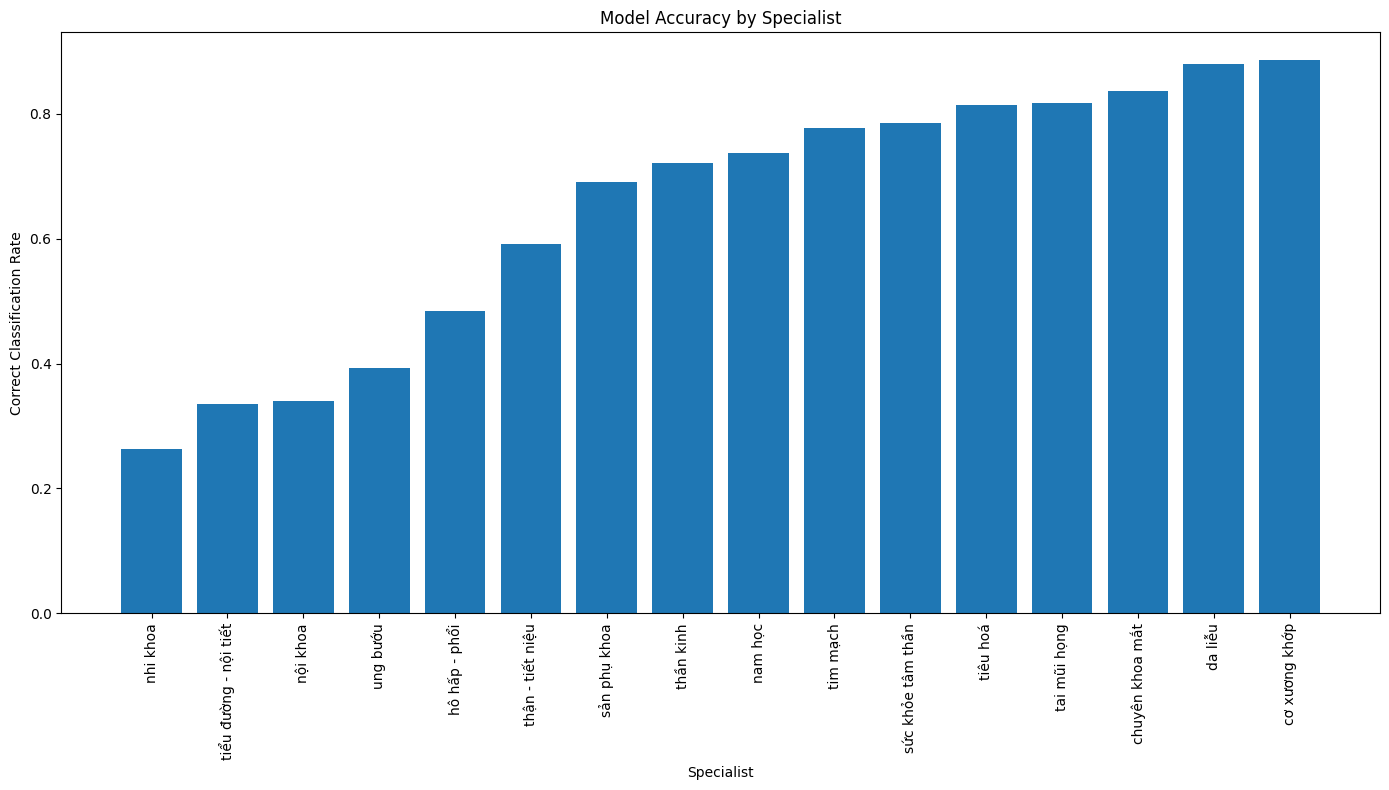

In [52]:
# Create a DataFrame to analyze misclassifications per specialist
specialist_stats = pd.DataFrame()

# Count total instances per specialist in test set
specialist_counts = X_test['target'].value_counts().reset_index()
specialist_counts.columns = ['specialist_id', 'total_count']
specialist_counts['specialist'] = label_encoder.inverse_transform(specialist_counts['specialist_id'])

# Count misclassifications per specialist
misclass_counts = misclassified['target'].value_counts().reset_index()
misclass_counts.columns = ['specialist_id', 'misclass_count']

# Merge the data
specialist_stats = pd.merge(specialist_counts, misclass_counts, on='specialist_id', how='left')
specialist_stats['misclass_count'] = specialist_stats['misclass_count'].fillna(0)

# Calculate misclassification rate
specialist_stats['misclass_rate'] = specialist_stats['misclass_count'] / specialist_stats['total_count']
specialist_stats['correct_rate'] = 1 - specialist_stats['misclass_rate']

# Sort by misclassification rate (highest first)
specialist_stats = specialist_stats.sort_values('misclass_rate', ascending=False)

# Display the results
print("Misclassification Statistics by Specialist:")
print(specialist_stats[['specialist', 'total_count', 'misclass_count', 'misclass_rate', 'correct_rate']])

# Visualize the results (optional)
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 8))
plt.bar(specialist_stats['specialist'], specialist_stats['correct_rate'])
plt.xlabel('Specialist')
plt.ylabel('Correct Classification Rate')
plt.title('Model Accuracy by Specialist')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [54]:
# Let's analyze the misclassifications between the specific specialists
# Assume "Nhi khoa" (pediatrics) is one of the specialist types

# Get the index for "Nhi khoa" in the label encoder
specialist_of_interest = "nhi khoa"
try:
    nhi_khoa_index = list(label_encoder.classes_).index(specialist_of_interest)
    print(f"Found '{specialist_of_interest}' with class index: {nhi_khoa_index}")
except ValueError:
    print(f"'{specialist_of_interest}' not found in specialists list")
    # List all available specialists
    print("Available specialists:")
    for i, spec in enumerate(label_encoder.classes_):
        print(f"{i}: {spec}")

# Analyze confusion between Nhi khoa and other specialists
if 'nhi_khoa_index' in locals():
    # Get all Nhi khoa cases in test set
    nhi_khoa_cases = X_test[X_test['target'] == nhi_khoa_index]
    print(f"\nTotal Nhi khoa cases in test set: {len(nhi_khoa_cases)}")
    
    # Analyze misclassified Nhi khoa cases
    misclassified_nhi_khoa = nhi_khoa_cases[nhi_khoa_cases['prediction'] != nhi_khoa_index]
    print(f"Misclassified Nhi khoa cases: {len(misclassified_nhi_khoa)} ({len(misclassified_nhi_khoa)/len(nhi_khoa_cases)*100:.2f}%)")
    
    # See which specialists Nhi khoa cases are misclassified as
    if len(misclassified_nhi_khoa) > 0:
        wrong_predictions = misclassified_nhi_khoa['prediction'].value_counts()
        wrong_specialists = label_encoder.inverse_transform(wrong_predictions.index)
        
        print("\nNhi khoa cases are misclassified as:")
        for i, count in enumerate(wrong_predictions):
            print(f"{wrong_specialists[i]}: {count} cases")
    
    # Analyze cases incorrectly classified as Nhi khoa
    other_cases_as_nhi_khoa = X_test[(X_test['target'] != nhi_khoa_index) & (X_test['prediction'] == nhi_khoa_index)]
    print(f"\nCases incorrectly classified as Nhi khoa: {len(other_cases_as_nhi_khoa)}")
    
    if len(other_cases_as_nhi_khoa) > 0:
        original_specialists = other_cases_as_nhi_khoa['target'].value_counts()
        original_specialists_names = label_encoder.inverse_transform(original_specialists.index)
        
        print("\nThese were actually:")
        for i, count in enumerate(original_specialists):
            print(f"{original_specialists_names[i]}: {count} cases")
            
    # Show some examples of misclassified Nhi khoa cases with reasons
    if len(misclassified_nhi_khoa) > 0:
        print("\nExamples of misclassified Nhi khoa cases:")
        sample = misclassified_nhi_khoa.sample(min(5, len(misclassified_nhi_khoa)))
        for _, row in sample.iterrows():
            predicted_specialist = label_encoder.inverse_transform([row['prediction']])[0]
            print(f"Reason: {row['reason_combind']}")
            print(f"Predicted as: {predicted_specialist}\n")


Found 'nhi khoa' with class index: 5

Total Nhi khoa cases in test set: 293
Misclassified Nhi khoa cases: 216 (73.72%)

Nhi khoa cases are misclassified as:
tai mũi họng: 40 cases
tiêu hoá: 34 cases
thần kinh: 32 cases
cơ xương khớp: 25 cases
da liễu: 21 cases
nam học: 18 cases
sức khỏe tâm thần: 14 cases
nội khoa: 11 cases
thận - tiết niệu: 4 cases
sản phụ khoa: 4 cases
tim mạch: 4 cases
hô hấp - phổi: 4 cases
chuyên khoa mắt: 3 cases
ung bướu: 2 cases

Cases incorrectly classified as Nhi khoa: 63

These were actually:
tai mũi họng: 15 cases
tiêu hoá: 11 cases
nội khoa: 8 cases
thần kinh: 8 cases
nam học: 4 cases
da liễu: 3 cases
hô hấp - phổi: 2 cases
cơ xương khớp: 2 cases
tiểu đường - nội tiết: 2 cases
tim mạch: 2 cases
chuyên khoa mắt: 2 cases
sức khỏe tâm thần: 2 cases
thận - tiết niệu: 1 cases
sản phụ khoa: 1 cases

Examples of misclassified Nhi khoa cases:
Reason: xuất hiện cơn co giật
Predicted as: thần kinh

Reason: đau đầu,nghi bị xoang
Predicted as: thần kinh

Reason: cần đ

In [59]:
model.save_model('../models/xgb_v5.1.json')

In [60]:
model = xgb.XGBClassifier()
model.load_model('../models/xgb_v5.1.json')

In [61]:
model

XGBClassifier(base_score='5E-1', booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)